In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import (LabelEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   PolynomialFeatures,
                                   OneHotEncoder)
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (VotingClassifier,
                              BaggingClassifier,
                              StackingClassifier)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier,
                              GradientBoostingClassifier)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="optuna.distributions")
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

In [ ]:
sns.set_theme()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from cuml.common import logger
logger.set_level(logger.level_enum.off)

In [ ]:
%load_ext cuml.accel

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/AI CHALLENGE/train.csv')

In [ ]:
data.shape

(5635, 20)

In [ ]:
data.dtypes

,0
id,int64
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [ ]:
data.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1162,Male,0,No,Yes,1,No,No phone service,DSL,No,Yes,No,No,No,No,Yes,Mailed check,31.35,31.35,Yes
1,2143,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,No,Mailed check,64.85,1336.8,No
2,1624,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,Bank transfer (automatic),97.20,5129.45,No
3,6075,Male,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Yes,Electronic check,23.45,23.45,Yes
4,1363,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Electronic check,70.20,237.95,Yes


In [ ]:
data['id'].unique().shape

(5635,)

In [ ]:
data.isna().sum()

,0
id,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
(data == ' ').any().sum()

np.int64(1)

In [ ]:
data.loc[data['TotalCharges'] == ' ', ['TotalCharges']] = '0'

In [ ]:
(data == ' ').any().sum()

np.int64(0)

In [ ]:
data['TotalCharges'] = data['TotalCharges'].astype('float64')

<Axes: xlabel='Churn', ylabel='count'>

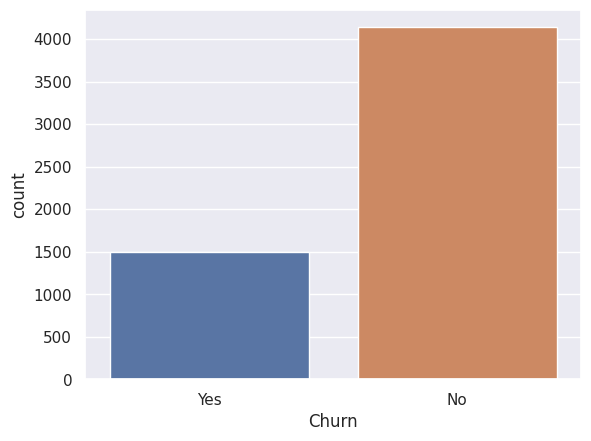

In [ ]:
sns.countplot(data, x='Churn', hue='Churn')

In [ ]:
for col in data.select_dtypes(include='object') :
  print(col, data[col].nunique())

gender 2
Partner 2
Dependents 2
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
PaperlessBilling 2
PaymentMethod 4
Churn 2


In [ ]:
data['gender'] = (data['gender'] == 'Male').astype('int64')

In [ ]:
for col in data.select_dtypes(include='object') :
  if data[col].nunique() == 2 :
    data[col] = (data[col] == 'Yes').astype('int64')

In [ ]:
for i, col in enumerate(data.select_dtypes(include='object')) :
  if data[col].nunique() == 3 :
    if i > 1 :
      data[col] = data[col].map({'No' : 0, 'Yes' : 1, 'No internet service' : -10})


In [ ]:
data['MultipleLines'] = data['MultipleLines'].map({'No' : 0, 'Yes' : 1, 'No phone service' : -10})

In [ ]:
data['InternetService'] = data['InternetService'].map({'No' : 0, 'DSL' : 1, 'Fiber optic' : 2})

In [ ]:
data['PaymentMethod'] = LabelEncoder().fit_transform(data['PaymentMethod'])

In [ ]:
def prepared(DATA : pd.DataFrame) :

  DATA = DATA.copy()

  DATA.loc[DATA['TotalCharges'] == ' ', ['TotalCharges']] = '0'
  """  DATA['gender'] = (DATA['gender'] == 'Male').astype('int64')

  for col in DATA.select_dtypes(include='object') :
    if DATA[col].nunique() == 2 :
      DATA[col] = (DATA[col] == 'Yes').astype('int64')

  for i, col in enumerate(DATA.select_dtypes(include='object')) :
    if DATA[col].nunique() == 3 :
      if i > 1 :
        DATA[col] = DATA[col].map({'No' : 0, 'Yes' : 1, 'No internet service' : -10})

  DATA['MultipleLines'] = DATA['MultipleLines'].map({'No' : 0, 'Yes' : 1, 'No phone service' : -10})
  DATA['InternetService'] = DATA['InternetService'].map({'No' : 0, 'DSL' : 1, 'Fiber optic' : 2})
  DATA['PaymentMethod'] = LabelEncoder().fit_transform(DATA['PaymentMethod'])"""

  return DATA.drop(columns=['id'])

In [ ]:
data.drop(columns=['id'], inplace=True)

In [ ]:
data['Churn'] = (data['Churn'] == 'Yes').astype('int64')

<Axes: >

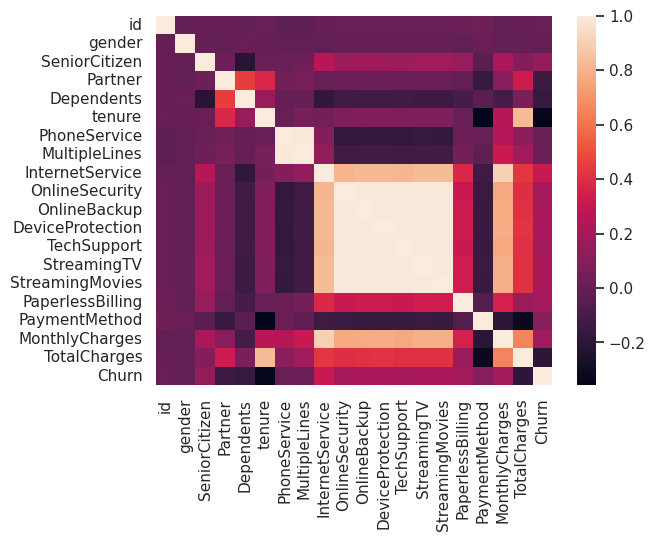

In [ ]:
sns.heatmap(data.corr())

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 24.3 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
import optuna

In [ ]:
X_train = data.iloc[:, :-1]
Y_train = data['Churn']

In [ ]:
X_train.shape

(5635, 18)

In [ ]:
data_test = pd.read_csv('/content/drive/MyDrive/AI CHALLENGE/test.csv')

In [ ]:
data_test.isna().sum()

,0
id,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
data_test_p = prepared(data_test)

In [ ]:
data_test_p

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Yes,Electronic check,24.80,24.8
1,Male,0,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,Bank transfer (automatic),25.25,996.45
2,Female,0,Yes,Yes,52,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,Mailed check,19.35,1031.7
3,Female,0,No,No,1,Yes,No,Fiber optic,No,No,Yes,No,No,No,No,Electronic check,76.35,76.35
4,Male,0,No,No,67,Yes,No,DSL,No,No,No,Yes,No,No,No,Bank transfer (automatic),50.55,3260.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,Female,0,Yes,Yes,69,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,No,Credit card (automatic),113.25,7895.15
1404,Female,0,Yes,No,64,Yes,No,DSL,No,Yes,Yes,Yes,No,Yes,Yes,Mailed check,68.30,4378.8
1405,Male,0,Yes,Yes,51,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,No,Credit card (automatic),110.05,5686.4
1406,Male,0,Yes,Yes,17,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,Bank transfer (automatic),19.90,329.75


## Random Forest

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=350, step=50)

    max_features = trial.suggest_categorical(name="max_features", choices=['sqrt'])

    max_depth = trial.suggest_int(name="max_depth", low=10, high=42, step=2)

    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=1)

    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=8, step=1)

    max_leaf_nodes = trial.suggest_int(name="max_leaf_nodes", low=15, high=40, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "max_leaf_nodes" : max_leaf_nodes
    }

    model = RandomForestClassifier(random_state=42, **params)
    pipe = make_pipeline(
        StandardScaler(),
        model
    )

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()

    return mean_cv_accuracy


### **With All Features**

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-07-08 13:08:00,937] A new study created in memory with name: no-name-bd44747c-1176-4c55-9132-ca88153eed5d
[I 2025-07-08 13:08:04,577] Trial 0 finished with value: 0.7835035841504213 and parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': 23}. Best is trial 0 with value: 0.7835035841504213.
[I 2025-07-08 13:08:08,419] Trial 1 finished with value: 0.7833703929988987 and parameters: {'n_estimators': 250, 'max_features': 'log2', 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_leaf_nodes': 23}. Best is trial 1 with value: 0.7833703929988987.
[I 2025-07-08 13:08:20,157] Trial 2 finished with value: 0.7850670232089925 and parameters: {'n_estimators': 250, 'max_features': 'log2', 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_leaf_nodes': 16}. Best is trial 1 with value: 0.7833703929988987.
[I 2025-07-08 13:08:25,055] Trial 3 finished with value: 0.78257822

In [ ]:
BestModel = RandomForestClassifier(random_state=42, **study.best_params)
BestPipeRBC = make_pipeline(
    StandardScaler(),
    BestModel
)

BestPipeRBC.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=30, max_leaf_nodes=20, n_estimators=300,
                       random_state=42))])

In [ ]:
data_test_p.shape

(1408, 18)

In [ ]:
Churn = BestPipeRBC.predict(data_test_p)

###**Drop Corrs**

In [ ]:
X_train = data.iloc[:, :-1].drop(columns=['OnlineSecurity',	"OnlineBackup",	"DeviceProtection",	"TechSupport",	"StreamingTV"])

In [ ]:
study2 = optuna.create_study()
study2.optimize(objective, n_trials=30)

[I 2025-07-08 13:05:25,737] A new study created in memory with name: no-name-003502da-e718-42c7-80e7-1918a4046d7d


NameError: name 'objective' is not defined

In [ ]:
BestModel = RandomForestClassifier(random_state=42, **study2.best_params)
BestPipeRBCWt = make_pipeline(
    StandardScaler(),
    BestModel
)

BestPipeRBCWt.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=34, max_leaf_nodes=32, min_samples_leaf=5,
                       min_samples_split=8, n_estimators=150, random_state=42))])

In [ ]:
Churn = BestPipeRBCWt.predict(data_test_p.drop(columns=['OnlineSecurity',	"OnlineBackup",	"DeviceProtection",	"TechSupport",	"StreamingTV"]))

### PCA

In [ ]:
def objectivePCA(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=325, step=25)

    max_features = trial.suggest_categorical(name="max_features", choices=['sqrt'])

    max_depth = trial.suggest_int(name="max_depth", low=6, high=30, step=2)

    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=1)

    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=7, step=1)

    max_leaf_nodes = trial.suggest_int(name="max_leaf_nodes", low=10, high=32, step=2)

    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "max_leaf_nodes" : max_leaf_nodes
    }

    pipe = make_pipeline(
        StandardScaler(),
        PCA(n_components=7),
        RandomForestClassifier(random_state=42, **params)
    )

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


In [ ]:
studyPCA = optuna.create_study()
studyPCA.optimize(objectivePCA, n_trials=25)

[I 2025-07-07 18:49:58,730] A new study created in memory with name: no-name-be186baf-7d83-4225-a553-4da51b998bef
[I 2025-07-07 18:50:04,813] Trial 0 finished with value: 0.7620705942687467 and parameters: {'n_estimators': 275, 'max_features': 'sqrt', 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_leaf_nodes': 20}. Best is trial 0 with value: 0.7620705942687467.
[I 2025-07-07 18:50:09,044] Trial 1 finished with value: 0.7609838355644032 and parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_leaf_nodes': 12}. Best is trial 1 with value: 0.7609838355644032.
[I 2025-07-07 18:50:10,804] Trial 2 finished with value: 0.7657749833459156 and parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_leaf_nodes': 32}. Best is trial 1 with value: 0.7609838355644032.
[I 2025-07-07 18:50:13,997] Trial 3 finished with value: 0.761020285

In [ ]:
BestModel = RandomForestClassifier(random_state=42, **studyPCA.best_params)
BestPipeRBCPCA = make_pipeline(
    StandardScaler(),
    PCA(n_components=7),
    BestModel
)

BestPipeRBCPCA.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=7)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=24, max_leaf_nodes=26, random_state=42))])

In [ ]:
Churn = BestPipeRBCPCA.predict(data_test_p)

### Prep2

In [ ]:
categorical_features = X_train.drop(columns=['tenure', 'MonthlyCharges', 'TotalCharges']).columns

continuous_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, ['tenure', 'MonthlyCharges', 'TotalCharges']),
        ('cat', 'passthrough', categorical_features)
    ])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), ['tenure', 'MonthlyCharges', 'TotalCharges']),
        ('cat', OneHotEncoder(), categorical_features)
    ])

preprocessor3 = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), ['tenure', 'MonthlyCharges', 'TotalCharges']),
        ('cat', OrdinalEncoder(), categorical_features)
    ])

In [ ]:
def objective2(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=400, step=50)

    max_features = trial.suggest_categorical(name="max_features", choices=['sqrt'])

    max_depth = trial.suggest_int(name="max_depth", low=16, high=42, step=2)

    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=12, step=1)

    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=10, step=1)

    max_leaf_nodes = trial.suggest_int(name="max_leaf_nodes", low=15, high=40, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "max_leaf_nodes" : max_leaf_nodes
    }

    model = RandomForestClassifier(random_state=42, **params)
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor2),
        ('model', model)
    ])

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()

    return mean_cv_accuracy


In [ ]:
RFCprep2 = optuna.create_study()
RFCprep2.optimize(objective2, n_trials=25)

[I 2025-07-09 19:41:00,153] A new study created in memory with name: no-name-42c05e81-041d-4db0-a0bd-12e41a835e4c
[I 2025-07-09 19:41:04,279] Trial 0 finished with value: 0.7752322070000275 and parameters: {'n_estimators': 250, 'max_features': 'sqrt', 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_leaf_nodes': 26}. Best is trial 0 with value: 0.7752322070000275.
[I 2025-07-09 19:41:13,220] Trial 1 finished with value: 0.7717547360167036 and parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_leaf_nodes': 17}. Best is trial 1 with value: 0.7717547360167036.
[I 2025-07-09 19:41:16,559] Trial 2 finished with value: 0.7753637486222443 and parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_leaf_nodes': 24}. Best is trial 1 with value: 0.7717547360167036.
[I 2025-07-09 19:41:18,380] Trial 3 finished with value: 0.777814

KeyboardInterrupt: 

## Бустинги

In [ ]:
def ADAprep(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=50, high=400, step=25)
    learning_rate = trial.suggest_float(name="learning_rate", low=1e-2, high=1.8, step=5e-3)

    params = {
        "n_estimators": n_estimators,
        "learning_rate" : learning_rate,
    }

    model = AdaBoostClassifier(random_state=42, **params)
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor2),
        ('model', model)
    ])

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


In [ ]:
studyADAp = optuna.create_study()
studyADAp.optimize(ADAprep, n_trials=50)

[I 2025-07-09 19:46:21,413] A new study created in memory with name: no-name-32099e1f-acfa-468b-8f3d-7e3cbf16b2e1
[I 2025-07-09 19:46:27,180] Trial 0 finished with value: 0.7899942784878922 and parameters: {'n_estimators': 200, 'learning_rate': 0.925}. Best is trial 0 with value: 0.7899942784878922.
[I 2025-07-09 19:46:36,736] Trial 1 finished with value: 0.7913475455949264 and parameters: {'n_estimators': 275, 'learning_rate': 0.5650000000000001}. Best is trial 0 with value: 0.7899942784878922.
[I 2025-07-09 19:46:41,716] Trial 2 finished with value: 0.7929818476770634 and parameters: {'n_estimators': 175, 'learning_rate': 1.73}. Best is trial 0 with value: 0.7899942784878922.
[I 2025-07-09 19:46:50,723] Trial 3 finished with value: 0.6767309880002969 and parameters: {'n_estimators': 225, 'learning_rate': 1.995}. Best is trial 3 with value: 0.6767309880002969.
[I 2025-07-09 19:46:56,687] Trial 4 finished with value: 0.7928072171627363 and parameters: {'n_estimators': 200, 'learning_ra

In [ ]:
def ADA(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=50, high=350, step=25)
    learning_rate = trial.suggest_float(name="learning_rate", low=1e-2, high=2, step=5e-3)

    params = {
        "n_estimators": n_estimators,
        "learning_rate" : learning_rate,
    }

    pipe = make_pipeline(
        StandardScaler(),
        AdaBoostClassifier(random_state=42, **params)
    )

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


In [ ]:
studyADA = optuna.create_study()
studyADA.optimize(ADA, n_trials=50)

In [ ]:
BestModel = AdaBoostClassifier(random_state=42, **{'n_estimators': 150, 'learning_rate': 1.0134999999999998})
BestPipeADA = make_pipeline(
    StandardScaler(),
    BestModel
)

BestPipeADA.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=1.0134999999999998,
                                    n_estimators=150, random_state=42))])

In [ ]:
BestModel = AdaBoostClassifier(random_state=42, **{'n_estimators': 200, 'learning_rate': 0.8545})
BestPipeADA = make_pipeline(
    StandardScaler(),
    BestModel
)

BestPipeADA.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=0.8545, n_estimators=200,
                                    random_state=42))])

In [ ]:
def XGB(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=50, high=350, step=25)

    max_depth = trial.suggest_int(name="max_depth", low=2, high=10, step=1)

    max_leaves = trial.suggest_int(name="max_leaves", low=1, high=40, step=1)

    learning_rate  = trial.suggest_float(name="learning_rate", low=1e-2, high=8e-1, step=1e-3)

    params = {
        "n_estimators": n_estimators,
        "max_leaves" : max_depth,
        "max_depth" : max_depth,
        "learning_rate" : learning_rate
    }

    pipe = make_pipeline(
        StandardScaler(),
        XGBClassifier(random_state=42, **params)
    )

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


In [ ]:
studyXGB = optuna.create_study()
studyXGB.optimize(XGB, n_trials=100)

In [ ]:
def XGBprep(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=50, high=350, step=25)

    max_depth = trial.suggest_int(name="max_depth", low=2, high=10, step=1)

    max_leaves = trial.suggest_int(name="max_leaves", low=1, high=50, step=1)

    learning_rate  = trial.suggest_float(name="learning_rate", low=1e-2, high=8e-1, step=1e-3)

    params = {
        "n_estimators": n_estimators,
        "max_leaves" : max_depth,
        "max_depth" : max_depth,
        "learning_rate" : learning_rate
    }

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor2),
        ('model', XGBClassifier(random_state=42, **params))
    ])

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


In [ ]:
studyXGBp = optuna.create_study()
studyXGBp.optimize(XGBprep, n_trials=100)

[I 2025-07-09 20:08:02,608] A new study created in memory with name: no-name-e22b739f-a9b8-4bd1-a68f-92d9d0324598
[I 2025-07-09 20:08:05,892] Trial 0 finished with value: 0.7942218433690348 and parameters: {'n_estimators': 175, 'max_depth': 8, 'max_leaves': 49, 'learning_rate': 0.067}. Best is trial 0 with value: 0.7942218433690348.
[I 2025-07-09 20:08:06,818] Trial 1 finished with value: 0.7779987159732219 and parameters: {'n_estimators': 175, 'max_depth': 9, 'max_leaves': 15, 'learning_rate': 0.389}. Best is trial 1 with value: 0.7779987159732219.
[I 2025-07-09 20:08:07,306] Trial 2 finished with value: 0.7855516193030108 and parameters: {'n_estimators': 75, 'max_depth': 4, 'max_leaves': 42, 'learning_rate': 0.776}. Best is trial 1 with value: 0.7779987159732219.
[I 2025-07-09 20:08:07,805] Trial 3 finished with value: 0.7866308201428767 and parameters: {'n_estimators': 50, 'max_depth': 9, 'max_leaves': 30, 'learning_rate': 0.382}. Best is trial 1 with value: 0.7779987159732219.
[I 2

KeyboardInterrupt: 

In [ ]:
def CAT(trial):
    iterations = trial.suggest_int(name="iterations", low=50, high=350, step=25)

    depth = trial.suggest_int(name="depth", low=2, high=12, step=1)

    max_leaves = trial.suggest_int(name="max_leaves", low=1, high=32, step=1)

    learning_rate  = trial.suggest_float(name="learning_rate", low=5e-3, high=1, step=1e-4)

    params = {
        "iterations": iterations,
        "depth" : depth,
        "learning_rate" : learning_rate
    }

    pipe = make_pipeline(
        StandardScaler(),
        CatBoostClassifier(random_state=42, logging_level='Silent', task_type='GPU', **params)
    )

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


In [ ]:
studyCAT = optuna.create_study()
studyCAT.optimize(CAT, n_trials=100)

In [ ]:
def CATprep(trial):
    iterations = trial.suggest_int(name="iterations", low=50, high=350, step=25)

    depth = trial.suggest_int(name="depth", low=2, high=12, step=1)

    max_leaves = trial.suggest_int(name="max_leaves", low=1, high=32, step=1)

    learning_rate  = trial.suggest_float(name="learning_rate", low=5e-3, high=1, step=1e-4)

    params = {
        "iterations": iterations,
        "depth" : depth,
        "learning_rate" : learning_rate
    }

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor2),
        ('model', CatBoostClassifier(random_state=42, logging_level='Silent', task_type='GPU', **params))
    ])

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


In [ ]:
studyCATp = optuna.create_study()
studyCATp.optimize(CATprep, n_trials=100)

[I 2025-07-09 20:02:05,052] A new study created in memory with name: no-name-16adc061-20c5-4a56-b4b1-5d0668b98b75
[I 2025-07-09 20:03:32,869] Trial 0 finished with value: 0.753714063791521 and parameters: {'iterations': 250, 'depth': 12, 'max_leaves': 19, 'learning_rate': 0.5215000000000001}. Best is trial 0 with value: 0.753714063791521.
[I 2025-07-09 20:03:54,690] Trial 1 finished with value: 0.7654682913472859 and parameters: {'iterations': 175, 'depth': 10, 'max_leaves': 4, 'learning_rate': 0.1266}. Best is trial 0 with value: 0.753714063791521.
[I 2025-07-09 20:04:02,677] Trial 2 finished with value: 0.7848132732907714 and parameters: {'iterations': 325, 'depth': 4, 'max_leaves': 7, 'learning_rate': 0.1048}. Best is trial 0 with value: 0.753714063791521.
[I 2025-07-09 20:04:51,038] Trial 3 finished with value: 0.7535070608837966 and parameters: {'iterations': 150, 'depth': 12, 'max_leaves': 4, 'learning_rate': 0.39890000000000003}. Best is trial 3 with value: 0.7535070608837966.
[

KeyboardInterrupt: 

## Voting

In [ ]:

ADAandRFC = make_pipeline(
    preprocessor3,
    VotingClassifier(
        estimators=[
          ('RFC1', RandomForestClassifier(
              random_state=42, **{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 38})),
          ('ADA1', AdaBoostClassifier(
              random_state=42, **{'n_estimators': 250, 'learning_rate': 1.4100000000000001})),
        ], voting='hard', weights=[5, 6]
    )
)

print(np.mean(cross_val_score(
        ADAandRFC,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))))

ADAandRFC.fit(X_train, Y_train)

0.7727218634169207


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cont', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat', OrdinalEncoder(),
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'Stre...
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('pca', PCA(n_components=14)),
                ('votingclassifier',
                 VotingClassifier(estimators=[('RFC1',
                                               RandomForestClassifier(max_depth=36,
                                                                      max_leaf_nodes=38,
                                                                      min_samples_leaf=10,
                                                                      n_estimators=200,
                                                                      random_state=42)),
                                              ('ADA1',
                                               AdaBoostClassifier(learning_rate=1.4100000000000001,
                                                                  n_estimators=250,
                                                                  random_state=42))],
                                  weights=[5, 6]))])

In [ ]:
{'n_estimators': 250, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_leaf_nodes': 26} {'n_estimators': 200, 'max_depth': 3, 'max_leaves' : 14, 'learning_rate' : 5e-2}  {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_leaf_nodes': 30}

In [ ]:
RAX = make_pipeline(
    StandardScaler(),
    VotingClassifier(
        estimators=[
          ('RFC1', RandomForestClassifier(random_state=42,
                                          **{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_leaf_nodes': 30})),
          ('ADA1', AdaBoostClassifier(random_state=42,
                                      **{'n_estimators': 200, 'learning_rate': 1.522})),
          ('XGB', XGBClassifier(
              **{'n_estimators': 200, 'max_depth': 3, 'max_leaves' : 14, 'learning_rate' : 5e-2}))
        ], voting='hard', weights=[2.5, 1.5, 1]
    )
)

print(np.mean(cross_val_score(
        RAX,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))))

RAX.fit(X_train, Y_train)

0.7883528786719785


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('votingclassifier',
                 VotingClassifier(estimators=[('RFC1',
                                               RandomForestClassifier(max_depth=38,
                                                                      max_leaf_nodes=30,
                                                                      min_samples_leaf=7,
                                                                      min_samples_split=5,
                                                                      random_state=42)),
                                              ('ADA1',
                                               AdaBoostClassifier(learning_rate=1.522,
                                                                  n_estimators=200,
                                                                  random_state=42)),
                                              ('XGB',
                                               XGBClassifier(base_score=None,
                                                             booster=Non...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=14,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))],
                                  weights=[1, 2.5, 3.5]))])

In [ ]:
CRAX = make_pipeline(
    StandardScaler(),
    VotingClassifier(
        estimators=[
          ('RFC1', RandomForestClassifier(random_state=42,
                                          **{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_leaf_nodes': 30})),
          ('ADA1', AdaBoostClassifier(random_state=42,
                                      **{'n_estimators': 200, 'learning_rate': 1.522})),
          ('XGB', XGBClassifier(random_state=42,
              **{'n_estimators': 200, 'max_depth': 3, 'max_leaves' : 14, 'learning_rate' : 5e-2})),
          ('Cat', CatBoostClassifier(random_state=42, logging_level='Silent', task_type='CPU', grow_policy='Lossguide',
                                      **{'iterations': 75, 'max_depth': 8, 'max_leaves': 34, 'learning_rate': 0.08299999999999999}))
        ], voting='hard', weights=[5, 6, 2, 3.1],
    )
)

print(np.mean(cross_val_score(
        CRAX,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))))

CRAX.fit(X_train, Y_train)

0.7895651456545997


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('votingclassifier',
                 VotingClassifier(estimators=[('RFC1',
                                               RandomForestClassifier(max_depth=38,
                                                                      max_leaf_nodes=30,
                                                                      min_samples_leaf=7,
                                                                      min_samples_split=5,
                                                                      random_state=42)),
                                              ('ADA1',
                                               AdaBoostClassifier(learning_rate=1.522,
                                                                  n_estimators=200,
                                                                  random_state=42)),
                                              ('XGB',
                                               XGBClassifier(base_score=None,
                                                             booster=Non...
                                                             learning_rate=0.05,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=14,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('Cat',
                                               <catboost.core.CatBoostClassifier object at 0x7c06f80ff790>)],
                                  weights=[5, 6, 2, 3.1]))])

In [ ]:
PolynomialFeatures(3).fit_transform(X_train)

array([[1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        3.08114854e+04, 3.08114854e+04, 3.08114854e+04],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.62194248e+06, 1.15889170e+08, 2.38890737e+09],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.84622229e+07, 2.55745421e+09, 1.34962279e+11],
       ...,
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.36903051e+05, 1.98104864e+06, 2.86666637e+07],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.18698465e+07, 1.43243804e+08, 1.72864808e+09],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.79279892e+05, 4.14064114e+06, 9.56320805e+07]])

In [ ]:
def SVCobj(trial):
    C = trial.suggest_float('C', 1e-2, 1e3, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    kernel = trial.suggest_categorical('kernel', ['rbf', 'sigmoid'])

    params = {
        "C": C,
        "gamma" : gamma,
        "kernel" : kernel
    }

    pipe = make_pipeline(
        preprocessor,
        PCA(n_components=14),
        SVC(**params)
    )

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

In [ ]:
studySVC = optuna.create_study()
studySVC.optimize(SVCobj, n_trials=20)

[I 2025-07-08 17:49:25,496] A new study created in memory with name: no-name-bfff8221-4a3c-40ff-8cfb-12f140168da9
[I 2025-07-08 17:49:30,794] Trial 0 finished with value: 0.6896127104133503 and parameters: {'C': 7.582111808467341, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.6896127104133503.
[I 2025-07-08 17:49:39,335] Trial 1 finished with value: 0.7788092208903941 and parameters: {'C': 45.64053599856271, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 0 with value: 0.6896127104133503.
[I 2025-07-08 17:49:48,673] Trial 2 finished with value: 0.7755307187563321 and parameters: {'C': 28.418887883783466, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 0 with value: 0.6896127104133503.
[I 2025-07-08 17:49:54,609] Trial 3 finished with value: 0.7137646013258815 and parameters: {'C': 0.8818830686234373, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.6896127104133503.
[I 2025-07-08 17:50:27,102] Trial 4 finished with value: 0.751588508698689

In [ ]:
SRAX = make_pipeline(
    StandardScaler(),
    VotingClassifier(
        estimators=[
          ('RFC1', RandomForestClassifier(random_state=42,
                                          **{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_leaf_nodes': 30})),
          ('ADA1', AdaBoostClassifier(random_state=42,
                                      **{'n_estimators': 200, 'learning_rate': 1.522})),
          ('SVC',  SVC(**{'C': 1.0352840711333962, 'gamma': 'auto', 'kernel': 'rbf'}))
        ], voting='hard', weights=[2.5, 1.7, 1.7]
    )
)

print(np.mean(cross_val_score(
        SRAX,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))))

SRAX.fit(X_train, Y_train)

0.781060071211669


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat', 'passthrough',
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', '...
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('RFC1',
                                               RandomForestClassifier(max_depth=38,
                                                                      max_leaf_nodes=30,
                                                                      min_samples_leaf=7,
                                                                      min_samples_split=5,
                                                                      random_state=42)),
                                              ('ADA1',
                                               AdaBoostClassifier(learning_rate=1.522,
                                                                  n_estimators=200,
                                                                  random_state=42)),
                                              ('SVC',
                                               SVC(C=1.0352840711333962,
                                                   gamma='auto'))],
                                  weights=[2.5, 1.7, 1.7]))])

In [ ]:
def LOGobj(trial):

    max_iter = trial.suggest_int(name='max_iter', low=100, high=550, step=25)

    solver_penalty_options = [
        ('lbfgs', 'l2', None),
        ('lbfgs', None, None),
        ('liblinear', 'l2', None),
        ('liblinear', 'l1', None),
        ('saga', 'elasticnet', 0.3),
        ('saga', 'l2', None),
        ('saga', 'l1', None)
    ]

    solver, penalty, l1_ratio  = trial.suggest_categorical('solver_penalty', solver_penalty_options)

    params = {
        "max_iter": max_iter,
        "solver": solver,
        "penalty": penalty,
        "l1_ratio" : l1_ratio
    }

    pipe = make_pipeline(
        preprocessor,
        PCA(n_components=14),
        LogisticRegression(random_state=42, class_weight='balanced', **params)
    )

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted')
    )

    return cv_score.mean()

In [ ]:
studyLOG = optuna.create_study()
studyLOG.optimize(LOGobj, n_trials=50)

[I 2025-07-08 17:48:19,028] A new study created in memory with name: no-name-ba34a19d-0f83-4408-810c-52dc06f4eee7
[I 2025-07-08 17:48:20,694] Trial 0 finished with value: 0.7518576732114066 and parameters: {'max_iter': 375, 'solver_penalty': ('liblinear', 'l2', None)}. Best is trial 0 with value: 0.7518576732114066.
[I 2025-07-08 17:48:22,298] Trial 1 finished with value: 0.7515004299491895 and parameters: {'max_iter': 125, 'solver_penalty': ('saga', 'elasticnet', 0.3)}. Best is trial 1 with value: 0.7515004299491895.
[I 2025-07-08 17:48:23,046] Trial 2 finished with value: 0.7518576732114066 and parameters: {'max_iter': 150, 'solver_penalty': ('lbfgs', 'l2', None)}. Best is trial 1 with value: 0.7515004299491895.
[I 2025-07-08 17:48:23,850] Trial 3 finished with value: 0.7516612100542253 and parameters: {'max_iter': 225, 'solver_penalty': ('saga', 'l2', None)}. Best is trial 1 with value: 0.7515004299491895.
[I 2025-07-08 17:48:24,158] Trial 4 finished with value: 0.7518576732114066 a

In [ ]:
def ADAPCA(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=50, high=350, step=25)
    learning_rate = trial.suggest_float(name="learning_rate", low=65e-3, high=2, step=5e-3)

    params = {
        "n_estimators": n_estimators,
        "learning_rate" : learning_rate,
    }

    pipe = make_pipeline(
        preprocessor,
        PCA(n_components=14),
        AdaBoostClassifier(random_state=42, **params)
    )

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


In [ ]:
studyADA = optuna.create_study()
studyADA.optimize(ADAPCA, n_trials=30)

[I 2025-07-08 17:52:55,557] A new study created in memory with name: no-name-0ce1631d-662a-49e0-922c-3f861c161740
[I 2025-07-08 17:53:13,513] Trial 0 finished with value: 0.7788127844465317 and parameters: {'n_estimators': 200, 'learning_rate': 0.79}. Best is trial 0 with value: 0.7788127844465317.
[I 2025-07-08 17:53:22,739] Trial 1 finished with value: 0.7778371509665809 and parameters: {'n_estimators': 100, 'learning_rate': 0.75}. Best is trial 1 with value: 0.7778371509665809.
[I 2025-07-08 17:53:30,869] Trial 2 finished with value: 0.7812046077979049 and parameters: {'n_estimators': 100, 'learning_rate': 1.02}. Best is trial 1 with value: 0.7778371509665809.
[I 2025-07-08 17:53:42,046] Trial 3 finished with value: 0.768156687287491 and parameters: {'n_estimators': 125, 'learning_rate': 1.905}. Best is trial 3 with value: 0.768156687287491.
[I 2025-07-08 17:54:11,710] Trial 4 finished with value: 0.7796970341379198 and parameters: {'n_estimators': 350, 'learning_rate': 1.445}. Best

In [ ]:
def XGBPCA(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=50, high=400, step=25)

    max_depth = trial.suggest_int(name="max_depth", low=2, high=10, step=1)

    max_leaves = trial.suggest_int(name="max_leaves", low=1, high=48, step=1)

    learning_rate  = trial.suggest_float(name="learning_rate", low=1e-2, high=8e-1, step=1e-3)

    params = {
        "n_estimators": n_estimators,
        "max_leaves" : max_depth,
        "max_depth" : max_depth,
        "learning_rate" : learning_rate
    }

    pipe = make_pipeline(
        preprocessor,
        PCA(12),
        XGBClassifier(random_state=42, **params)
    )

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


In [ ]:
studyXBG = optuna.create_study()
studyXBG.optimize(XGBPCA, n_trials=50)

[I 2025-07-08 18:07:01,179] A new study created in memory with name: no-name-b0e5c37f-9742-4457-8666-e19cafb3a061
[I 2025-07-08 18:07:02,724] Trial 0 finished with value: 0.7688798711603179 and parameters: {'n_estimators': 175, 'max_depth': 5, 'max_leaves': 26, 'learning_rate': 0.62}. Best is trial 0 with value: 0.7688798711603179.
[I 2025-07-08 18:07:03,978] Trial 1 finished with value: 0.7737152312537823 and parameters: {'n_estimators': 175, 'max_depth': 4, 'max_leaves': 36, 'learning_rate': 0.59}. Best is trial 0 with value: 0.7688798711603179.
[I 2025-07-08 18:07:05,576] Trial 2 finished with value: 0.7838103946731517 and parameters: {'n_estimators': 150, 'max_depth': 8, 'max_leaves': 27, 'learning_rate': 0.233}. Best is trial 0 with value: 0.7688798711603179.
[I 2025-07-08 18:07:07,511] Trial 3 finished with value: 0.7660302238992782 and parameters: {'n_estimators': 175, 'max_depth': 10, 'max_leaves': 6, 'learning_rate': 0.41500000000000004}. Best is trial 3 with value: 0.76603022

In [ ]:
categorical_features = X_train.drop(columns=['tenure', 'MonthlyCharges', 'TotalCharges']).columns

continuous_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, ['tenure', 'MonthlyCharges', 'TotalCharges']),
        ('cat', 'passthrough', categorical_features)
    ])

ALS = make_pipeline(
    preprocessor,
    PCA(n_components=14),
    VotingClassifier(
        estimators=[
          ('ADA1', AdaBoostClassifier(random_state=42,
                                      **{'n_estimators': 100, 'learning_rate': 1.02})),
          ('SVC',  SVC(**{'C': 45.64053599856271, 'gamma': 'scale', 'kernel': 'rbf'})),
          ('LOG', LogisticRegression(random_state=42, **{'max_iter': 200, 'solver' : 'saga', "penalty" : 'l1'}))
        ], voting='hard', weights=[2, 1.7, 0.9]
    )
)

print(np.mean(cross_val_score(
        ALS,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))))

ALS.fit(X_train, Y_train)

0.7832536176746722


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat', 'passthrough',
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', '...
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('pca', PCA(n_components=14)),
                ('votingclassifier',
                 VotingClassifier(estimators=[('ADA1',
                                               AdaBoostClassifier(learning_rate=1.02,
                                                                  n_estimators=100,
                                                                  random_state=42)),
                                              ('SVC', SVC(C=45.64053599856271)),
                                              ('LOG',
                                               LogisticRegression(max_iter=200,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='saga'))],
                                  weights=[2, 1.7, 0.9]))])

In [ ]:
categorical_features = X_train.drop(columns=['tenure', 'MonthlyCharges', 'TotalCharges']).columns

continuous_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, ['tenure', 'MonthlyCharges', 'TotalCharges']),
        ('cat', 'passthrough', categorical_features)
    ])

XLS = make_pipeline(
    preprocessor,
    PCA(n_components=14),
    VotingClassifier(
        estimators=[
          ('XGB', XGBClassifier(random_state=42,
                                      **{'n_estimators': 150, 'max_depth': 8, 'max_leaves': 27, 'learning_rate': 0.233})),
          ('SVC',  SVC(**{'C': 45.64053599856271, 'gamma': 'scale', 'kernel': 'rbf'})),
          ('LOG', LogisticRegression(random_state=42, **{'max_iter': 200, 'solver' : 'saga', "penalty" : 'l1'}))
        ], voting='hard', weights=[2, 1.7, .9]
    )
)

print(np.mean(cross_val_score(
        XLS,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))))

XLS.fit(X_train, Y_train)

0.7815088291260153


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat', 'passthrough',
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', '...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=8,
                                                             max_leaves=27,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=150,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('SVC', SVC(C=45.64053599856271)),
                                              ('LOG',
                                               LogisticRegression(max_iter=200,
                                                                  penalty='l1',
                                                                  random_state=42,
                                                                  solver='saga'))],
                                  weights=[2, 1.7, 2.9]))])

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
def LBM(trial):

    n_estimators = trial.suggest_int(name="n_estimators", low=50, high=500, step=20)

    learning_rate  = trial.suggest_float(name="learning_rate", low=1e-2, high=1.2, step=1e-3)

    max_depth = trial.suggest_int(name="max_depth", low=1, high=12, step=1)

    boosting_type = trial.suggest_categorical(name="boosting_type", choices=['gbdt', 'dart', 'goss'])

    params = {
        "n_estimators": n_estimators,
        "boosting_type" : boosting_type,
        "max_depth" : max_depth,
        "learning_rate" : learning_rate
    }


    pipe = make_pipeline(
        StandardScaler(),
        LGBMClassifier(random_state=42, verbose=-1, **params)
    )

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy


In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.deprecation")

In [ ]:
studyLBM = optuna.create_study()
studyLBM.optimize(LBM, n_trials=100)

[I 2025-07-08 19:08:28,036] A new study created in memory with name: no-name-ca60de97-3307-4c19-baf8-4d8940ab40b5
[I 2025-07-08 19:08:29,020] Trial 0 finished with value: 0.790708007960263 and parameters: {'n_estimators': 470, 'learning_rate': 0.445, 'max_depth': 1, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.790708007960263.
[I 2025-07-08 19:08:30,123] Trial 1 finished with value: 0.7449970396545578 and parameters: {'n_estimators': 170, 'learning_rate': 1.111, 'max_depth': 12, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.7449970396545578.
[I 2025-07-08 19:08:31,040] Trial 2 finished with value: 0.7411972647695351 and parameters: {'n_estimators': 130, 'learning_rate': 1.032, 'max_depth': 9, 'boosting_type': 'gbdt'}. Best is trial 2 with value: 0.7411972647695351.
[I 2025-07-08 19:08:39,226] Trial 3 finished with value: 0.7624059896420846 and parameters: {'n_estimators': 270, 'learning_rate': 0.673, 'max_depth': 12, 'boosting_type': 'dart'}. Best is trial 2 with v

KeyboardInterrupt: 

In [ ]:
def LBMp(trial):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=400, step=50)

    max_features = trial.suggest_categorical(name="max_features", choices=['sqrt'])

    max_depth = trial.suggest_int(name="max_depth", low=16, high=42, step=2)

    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=12, step=1)

    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=10, step=1)

    max_leaf_nodes = trial.suggest_int(name="max_leaf_nodes", low=15, high=40, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "max_leaf_nodes" : max_leaf_nodes
    }

    model = RandomForestClassifier(random_state=42, **params)
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor2),
        ('model', model)
    ])

    cv_score = cross_val_score(
        pipe,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))

    mean_cv_accuracy = cv_score.mean()

    return mean_cv_accuracy


In [ ]:
{'n_estimators': 375, 'learning_rate': 1.125, 'max_depth': 1, 'boosting_type': 'dart'}
{'n_estimators': 175, 'learning_rate': 0.093, 'max_depth': 3, 'boosting_type': 'gbdt'}
{'n_estimators': 325, 'learning_rate': 0.11499999999999999, 'max_depth': 10, 'boosting_type': 'dart'}

In [ ]:
categorical_features = X_train.drop(columns=['tenure', 'MonthlyCharges', 'TotalCharges']).columns

continuous_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, ['tenure', 'MonthlyCharges', 'TotalCharges']),
        ('cat', OneHotEncoder(), categorical_features)
    ])

LMBCompany = make_pipeline(
    preprocessor,
    VotingClassifier(
        estimators=[
          ('LMB1', LGBMClassifier(random_state=42,
                                      **{'n_estimators': 375, 'learning_rate': 1.125, 'max_depth': 1, 'boosting_type': 'dart'})),
          ('LMB2', LGBMClassifier(random_state=42,
                                      **{'n_estimators': 430, 'learning_rate': 0.919, 'max_depth': 1, 'boosting_type': 'gbdt'})),
          ('LMB3', LGBMClassifier(random_state=42,
                                      **{'n_estimators': 470, 'learning_rate': 0.445, 'max_depth': 1, 'boosting_type': 'gbdt'})),
        ], voting='soft', weights=[5, 3, 4]
    )
)

print(np.mean(cross_val_score(
        LMBCompany,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))))

LMBCompany.fit(X_train, Y_train)

0.7871038753876711


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService'...
                 VotingClassifier(estimators=[('LMB1',
                                               LGBMClassifier(boosting_type='dart',
                                                              learning_rate=1.125,
                                                              max_depth=1,
                                                              n_estimators=375,
                                                              random_state=42)),
                                              ('LMB2',
                                               LGBMClassifier(learning_rate=0.919,
                                                              max_depth=1,
                                                              n_estimators=430,
                                                              random_state=42)),
                                              ('LMB3',
                                               LGBMClassifier(learning_rate=0.445,
                                                              max_depth=1,
                                                              n_estimators=470,
                                                              random_state=42))],
                                  voting='soft', weights=[5, 3, 5]))])

In [ ]:

LBMStack = make_pipeline(
  StandardScaler(),
  PCA(8),
  StackingClassifier(estimators=[
      ('XGB', DecisionTreeClassifier()),
      ('LGBM', LogisticRegression()),
      ('SVC',  SVC()),
      ('KNN', KNeighborsClassifier())
  ], final_estimator=LGBMClassifier(random_state=42,
                                      **{'n_estimators': 470, 'learning_rate': 0.445, 'max_depth': 1, 'boosting_type': 'gbdt'}))
)


print(np.mean(cross_val_score(
        LBMStack,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))))

LBMStack.fit(X_train, Y_train)

0.7701359678339825


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=8)),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('XGB',
                                                 DecisionTreeClassifier()),
                                                ('LGBM', LogisticRegression()),
                                                ('SVC', SVC()),
                                                ('KNN',
                                                 KNeighborsClassifier())],
                                    final_estimator=LGBMClassifier(learning_rate=0.445,
                                                                   max_depth=1,
                                                                   n_estimators=470,
                                                                   random_state=42)))])

In [ ]:
RFCStack = make_pipeline(
  preprocessor2,
  StackingClassifier(estimators=[
      ('XGB', XGBClassifier(**{'n_estimators': 175, 'max_depth': 8, 'max_leaves': 49, 'learning_rate': 0.067})),
      ('ADA', AdaBoostClassifier(
              random_state=42, ** {'n_estimators': 150, 'learning_rate': 1.47}) )
  ], final_estimator=RandomForestClassifier(
              random_state=42, **{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 38}))
)

print(np.mean(cross_val_score(
        RFCStack,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))))

0.7876155841929284


In [ ]:

XGBStack = make_pipeline(
  preprocessor2,
  StackingClassifier(estimators=[
      ('SVC',  SVC(**{'C': 45.64053599856271, 'gamma': 'scale', 'kernel': 'rbf'})),
      ('LOG', LogisticRegression(random_state=42, **{'max_iter': 200, 'solver' : 'saga', "penalty" : 'l1'}))
  ], final_estimator=XGBClassifier(**{'n_estimators': 175, 'max_depth': 8, 'max_leaves': 49, 'learning_rate': 0.067}))
)

print(np.mean(cross_val_score(
        XGBStack,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))))

0.7741332696564737


In [ ]:
xgbb = make_pipeline(
  preprocessor2, XGBClassifier(**{'n_estimators': 175, 'max_depth': 8, 'max_leaves': 49, 'learning_rate': 0.067})).fit(X_train, Y_train)

In [ ]:
XGBADA = make_pipeline(
    preprocessor2,
    VotingClassifier(
        estimators=[
          ('RFC1', XGBClassifier(**{'n_estimators': 175, 'max_depth': 8, 'max_leaves': 49, 'learning_rate': 0.067})),
          ('ADA1', AdaBoostClassifier(
              random_state=42, **{'n_estimators': 250, 'learning_rate': 1.4100000000000001})),

          ('RFC', RandomForestClassifier(
              random_state=42, **{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_leaf_nodes': 38})),
          ('LOG', LogisticRegression(random_state=42, **{'max_iter': 200, 'solver' : 'saga', "penalty" : 'l1'})),
          ('CAT', CatBoostClassifier(random_state=42, logging_level='Silent', grow_policy='Lossguide', task_type='GPU', **{'iterations': 325, 'depth': 4, 'max_leaves': 7, 'learning_rate': 0.1048}))
        ], voting='soft', weights=[15, 6, 9, 3, 6]
    )
)

print(np.mean(cross_val_score(
        XGBADA,
        X=X_train,
        y=Y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=make_scorer(f1_score, average='weighted'))))

0.7902925446595624


In [ ]:
XGBADA.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cont', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'Strea...
                                               AdaBoostClassifier(learning_rate=1.4100000000000001,
                                                                  n_estimators=250,
                                                                  random_state=42)),
                                              ('RFC',
                                               RandomForestClassifier(max_depth=36,
                                                                      max_leaf_nodes=38,
                                                                      min_samples_leaf=10,
                                                                      n_estimators=200,
                                                                      random_state=42)),
                                              ('LOG',
                                               LogisticRegression(max_iter=200, penalty='l1', random_state=42, solver='saga')),
                                              ('CAT',
                                               <catboost.core.CatBoostClassifier object at 0x7b56b2c94b90>)],
                                  voting='soft', weights=[15, 6, 9, 3, 6]))])

## А давайте нейронку используем

In [ ]:
def preprocessor() :
  return ColumnTransformer(
      transformers=[
          ('cont', StandardScaler(), ['tenure', 'MonthlyCharges', 'TotalCharges']),
          ('cat', OrdinalEncoder(), ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod'])
      ])

In [ ]:
import torch
from torch.nn import (
    Module,
    ReLU,
    LeakyReLU,
    Sigmoid,
    BCELoss,
    Linear,
    Dropout,
    Sequential,
    BatchNorm1d,
    Flatten,
    BCEWithLogitsLoss
)

from torch.optim import SGD, AdamW, Adam
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
class TrueNN(Module):
    def __init__(self,
                 layers,
                 optim,
                 crit):
        super(TrueNN, self).__init__()

        self.net = Sequential(*layers)
        self.criterion = crit
        self.optim = optim[0](params=self.parameters(), **optim[1])

    def train_model(self, train_loader, test_loader, n_epochs=100, plot=True, return_best=True, name='') :
        self.train()

        test_loss = []
        correct = []
        bestacc = 0

        for epoch in range(n_epochs):
          model.train()
          running_loss = 0.0

          for batch_X, batch_y in train_loader :

              self.optim.zero_grad()
              outputs = model(batch_X)
              loss = self.criterion(outputs, batch_y)
              loss.backward()
              self.optim.step()

              running_loss += loss.item() * batch_X.size(0)

          epoch_loss = running_loss / len(train_loader)
          print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")
          avg_loss, accuracy = self.test_model(test_loader)
          if accuracy > bestacc :
            torch.save(self.state_dict(), f'm{name}.pth')
            print('Best saved')
            bestacc = accuracy
          test_loss.append(avg_loss)
          correct.append(accuracy)

        if plot  :
          sns.lineplot(x=np.arange(1, n_epochs + 1), y=test_loss)
          sns.lineplot(x=np.arange(1, n_epochs + 1), y=correct)

    def test_model(self, test_loader) :
      self.eval()
      test_loss = []
      correct = []

      with torch.no_grad():
          for inputs, labels in test_loader:
              outputs = self(inputs)
              loss = self.criterion(outputs, labels)

              predicted = (outputs > 0.5).int()

              test_loss += [loss.item()] * len(labels)
              correct += list(predicted == labels)

      avg_loss = np.mean(test_loss)
      accuracy = np.mean(correct)

      print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')
      return avg_loss, accuracy

    def forward(self, x):
        return self.net(x).squeeze(1)


Epoch 1/50, Loss: 14.4785
Test Loss: 0.8208, Test Accuracy: 0.7239
Best saved
Epoch 2/50, Loss: 12.7158
Test Loss: 0.7928, Test Accuracy: 0.7268
Best saved
Epoch 3/50, Loss: 12.3446
Test Loss: 0.7860, Test Accuracy: 0.7317
Best saved
Epoch 4/50, Loss: 12.4121
Test Loss: 0.7902, Test Accuracy: 0.7104
Epoch 5/50, Loss: 12.1219
Test Loss: 0.7955, Test Accuracy: 0.7417
Best saved
Epoch 6/50, Loss: 12.0904
Test Loss: 0.7927, Test Accuracy: 0.7374
Epoch 7/50, Loss: 12.1055
Test Loss: 0.8018, Test Accuracy: 0.7559
Best saved
Epoch 8/50, Loss: 12.0010
Test Loss: 0.7855, Test Accuracy: 0.7218
Epoch 9/50, Loss: 12.1942
Test Loss: 0.7882, Test Accuracy: 0.7126
Epoch 10/50, Loss: 11.8388
Test Loss: 0.7850, Test Accuracy: 0.7083
Epoch 11/50, Loss: 12.2081
Test Loss: 0.7888, Test Accuracy: 0.7062
Epoch 12/50, Loss: 11.9050
Test Loss: 0.7888, Test Accuracy: 0.7317
Epoch 13/50, Loss: 11.9323
Test Loss: 0.7870, Test Accuracy: 0.7126
Epoch 14/50, Loss: 11.8063
Test Loss: 0.7828, Test Accuracy: 0.7111
Ep

TrueNN(
  (net): Sequential(
    (0): Linear(in_features=18, out_features=37, bias=True)
    (1): BatchNorm1d(37, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=37, out_features=65, bias=True)
    (5): BatchNorm1d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=65, out_features=25, bias=True)
    (9): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=25, out_features=1, bias=True)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (criterion): BCEWithLogitsLoss()
)

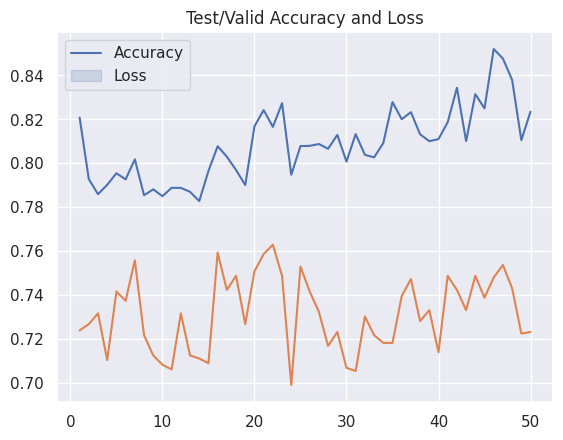

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(
    data.iloc[:, :-1],
    data['Churn'],
    stratify=data['Churn'],
    random_state=42
)

prep = preprocessor()
prep.fit(X_train)
X_train = prep.transform(X_train)
X_test = prep.transform(X_test)

dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(Y_train.to_numpy()).float())
batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

datasetTest = TensorDataset(torch.tensor(X_test).float(), torch.tensor(Y_test.to_numpy()).float())
batch_size = 16
test_loader = DataLoader(datasetTest, batch_size=batch_size, shuffle=True)

class_weights = compute_class_weight(
            y=Y_train,
            class_weight='balanced',
            classes=Y_train.unique()
        )

model = TrueNN([
    Linear(X.shape[1], X.shape[1] * 2 + 1),
    BatchNorm1d(X.shape[1] * 2 + 1),
    ReLU(),
    Dropout(0.1),
    Linear(X.shape[1] * 2 + 1, 65),
    BatchNorm1d(65),
    ReLU(),
    Dropout(0.1),
    Linear(65, 25),
    BatchNorm1d(25),
    ReLU(),
    Linear(25, 1),
    Flatten()],
    (SGD, {"lr" : 0.001, "momentum" : 0.9}),
    BCEWithLogitsLoss(pos_weight=torch.tensor([Y_train[Y_train == 0].shape[0] / Y_train[Y_train == 1].shape[0]])))

model.train_model(train_loader, test_loader, 50, plot=True, name=f'{0}')
model.load_state_dict(torch.load(f'm{0}.pth'))
model.eval()

In [ ]:
preds = (torch.sigmoid(model(torch.tensor(X_test).float())).detach().cpu() > 0.5).int().numpy()
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.54      0.67      0.60       374

    accuracy                           0.76      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.76      0.77      1409



In [ ]:
prep = preprocessor().fit(data.iloc[:, :-1])
X = prep.transform(data.iloc[:, :-1])

dataset = TensorDataset(torch.tensor(X).float(), torch.tensor(data['Churn'].to_numpy()).float())
batch_size = 32
gen_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Epoch 1/50, Loss: 19.0595
Test Loss: 0.5375, Test Accuracy: 0.7461
Best saved
Epoch 2/50, Loss: 16.1827
Test Loss: 0.4936, Test Accuracy: 0.7618
Best saved
Epoch 3/50, Loss: 15.4161
Test Loss: 0.4623, Test Accuracy: 0.7741
Best saved
Epoch 4/50, Loss: 15.1232
Test Loss: 0.4589, Test Accuracy: 0.7821
Best saved
Epoch 5/50, Loss: 14.8228
Test Loss: 0.4514, Test Accuracy: 0.7839
Best saved
Epoch 6/50, Loss: 14.6362
Test Loss: 0.4430, Test Accuracy: 0.7881
Best saved
Epoch 7/50, Loss: 14.6691
Test Loss: 0.4491, Test Accuracy: 0.7849
Epoch 8/50, Loss: 14.7611
Test Loss: 0.4366, Test Accuracy: 0.7906
Best saved
Epoch 9/50, Loss: 14.4725
Test Loss: 0.4358, Test Accuracy: 0.7957
Best saved
Epoch 10/50, Loss: 14.3817
Test Loss: 0.4338, Test Accuracy: 0.7922
Epoch 11/50, Loss: 14.3954
Test Loss: 0.4358, Test Accuracy: 0.7952
Epoch 12/50, Loss: 14.4980
Test Loss: 0.4368, Test Accuracy: 0.7911
Epoch 13/50, Loss: 14.2889
Test Loss: 0.4294, Test Accuracy: 0.7963
Best saved
Epoch 14/50, Loss: 14.2552

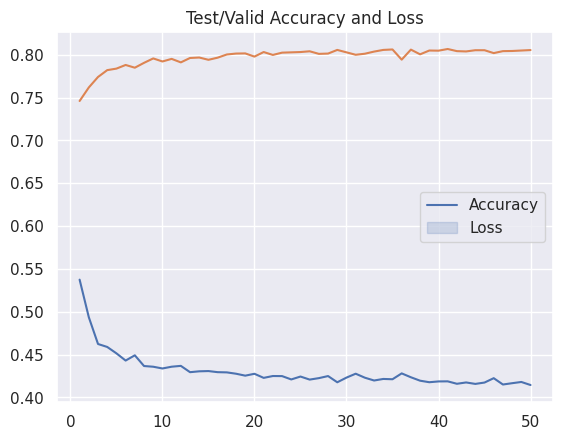

In [ ]:

model = TrueNN([
    Linear(X.shape[1], X.shape[1] * 2 + 1),
    BatchNorm1d(X.shape[1] * 2 + 1),
    ReLU(),
    Dropout(0.1),
    Linear(X.shape[1] * 2 + 1, 60),
    BatchNorm1d(60),
    ReLU(),
    Dropout(0.3),
    Linear(60, 25),
    BatchNorm1d(25),
    ReLU(),
    Linear(25, 1),
    Flatten()],
    (SGD, {"lr" : 0.001, "momentum" : 0.9}),
    BCEWithLogitsLoss(pos_weight=torch.tensor([data[data == 0].shape[0] / data[data == 1].shape[0]])))

model.train_model(gen_loader, gen_loader, 50, plot=True, name=f'JHON')
model.load_state_dict(torch.load('mJHON.pth'))
model.eval()
data_test_p = prep.transform(prepared(data_test))

In [ ]:
Churn = (torch.sigmoid(model(torch.tensor(data_test_p).float())) > 0.5).int()
Churn.count_nonzero()

tensor(284)

## Submit

In [ ]:
df = pd.DataFrame({'id' : data_test['id'], 'Churn' : Churn})

df['Churn'] = df['Churn'].map({1 : 'Yes', 0 : 'No'})

df.to_csv('NN.csv', sep=',')

In [ ]:
df

,id,Churn
0,186,Yes
1,2716,No
2,3826,No
3,1808,Yes
4,133,No
...,...,...
1403,16,No
1404,6367,No
1405,316,No
1406,2440,No
